In [2]:
# my own functions
# watch for any changes in the utils module, and reload it automatically
%load_ext autoreload
%autoreload 2
# load my own functions
from utils.functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### See presentation [here](https://docs.google.com/presentation/d/1ngXLMdhl9e7SIO6-CndaqdoknSf7j-ofYeCvVgOqGS8/edit#slide=id.p21)

Using a simple linear regression example, but using input-dependent noise, we will discuss the following:

Understand why constant input-dependent uncertainty can be useful
Discuss methods to achieve input-dependent uncertainty:
Heteroscedastic network
Quantile regression network
UMAL (Uncountable mixture of Asymmetric Laplacians).

In [3]:
# Generate training ant test: 
from sklearn.model_selection import train_test_split

X, y = generate_set(50000, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

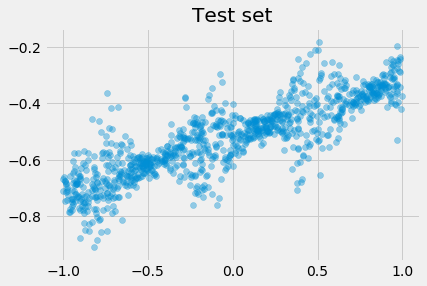

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
rp = np.random.permutation(X_train.shape[0])[:1000]

# Plot
plt.scatter(X_test[rp], y_test[rp], alpha=0.4)
_ = plt.title("Test set")

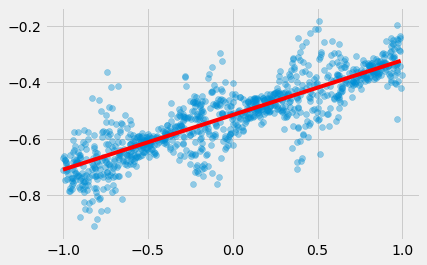

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train[:,None], y_train)

Xv = np.arange(-1, 1, 0.01)[:,None]
yhatv = lr.predict(Xv)

# Correct estimator for sigma: 
yhat_train = lr.predict(X_train[:,None])

plt.scatter(X_test[rp], y_test[rp], alpha=0.4)
plt.plot(Xv, yhatv, 'r', linewidth=4)

sigma = 0.07054741389084589


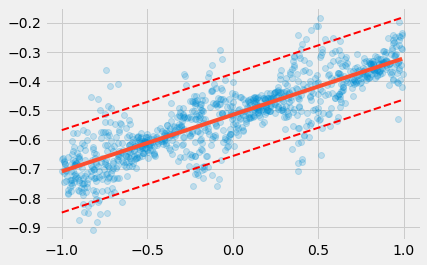

In [6]:
# Std of OLS is the std of distances
sigma = np.sqrt(np.square(yhat_train-y_train).mean())
print("sigma =", sigma)

plt.plot(X_test[rp],y_test[rp],'o', alpha=0.2)
plt.plot(Xv, yhatv, linewidth=4)
plt.plot(Xv, yhatv-2*sigma, 'r--', linewidth=2)
plt.plot(Xv, yhatv+2*sigma, 'r--', linewidth=2)
plt.show()

## **Method 1: Heteroscedastic networks**

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import Input
from keras import backend as K
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.engine.topology import Layer
import tensorflow as tf

import tensorflow as tf
#sess = tf.InteractiveSession()
sess=tf.compat.v1.InteractiveSession()
K.set_session(sess)

In [9]:
# Log of Gaussian likelihood
def log_normal_pdf(y, output_psi, epsilon):
    return -tf.log(epsilon)-(K.square(y-output_psi)/(2.*K.square(epsilon)))

# This is the expression corresponding to Equation (1) above! 

# Log-likelihood is negative because it is a fitness function (positive is better)
# and here it is taken as a loss function (negative is better). 
def regression(y_true, parameters):
    mu = parameters[:,:-1]
    sigma = parameters[:,-1:]
    return -K.sum(log_normal_pdf(y_true[:,:1],mu,sigma))

from keras.layers import ELU

def elu_plus1(x, a=1.):
    return ELU(alpha=a)(x)+1.

In [12]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


i = Input(name='input', shape=(1,), dtype='float32')

phi = Dense(units=1, activation="linear", name='w',
              kernel_initializer='ones')(i)

psi = Dense(units=120, activation="sigmoid", name='v_0')(i)
psi = Dense(units=12, activation="sigmoid", name='v_1')(psi)
psi = Dense(units=1, activation=elu_plus1, name='v_2')(psi)

model = Model(
    inputs=[i],
    outputs=[concatenate([phi,psi],  
                         axis=1, 
                         name='main_output')])

opt = Adam(lr=0.005)
model.compile(optimizer=opt, loss={'main_output':regression})



AttributeError: module 'tensorflow' has no attribute 'placeholder'